# **Movie Recommendation with LightGCN**






# Setup


In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.6.0+cu124


In [ ]:
!pip install tensorly
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 91.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 121.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 63.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.5 MB/s eta 0:00:00


In [ ]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

In [ ]:
print(f"PyTorch has version {torch.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

PyTorch has version 2.6.0+cu124
Torch version: 2.6.0+cu124
Cuda available: True
Torch geometric version: 2.6.1


# Configurations


In [ ]:
rating_threshold = 3  #@param {type: "integer"}: Ratings equal to or greater than 3 are positive items.

config_dict = {
    "num_samples_per_user": 50,
    "num_users": -1,

    "epochs": 21,
    "batch_size": 256,
    "lr": 0.001,
    "weight_decay": 0.1,

    "embedding_size": 32,
    "num_layers": 3,
    "K": 10,
    "mf_rank": 8,

    "minibatch_per_print": 500,
    "epochs_per_print": 1,

    "val_frac": 0.2,
    "test_frac": 0.1,

    "model_name": "model.pth"
}

# Dataset

The MovieLens 1M dataset consists of 1 million movie ratings of score 1 to 5, from 6000 users and 4000 movies.

In [ ]:
DATA_PATH = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"

In [ ]:
def trans_ml(dat, thres):
    """
    Transform function that assign non-negative entries >= thres 1, and non-
    negative entries <= thres 0. Keep other entries the same.
    """
    thres = thres[0]
    matrix = dat['edge_index']
    matrix[(matrix < thres) & (matrix > -1)] = 0
    matrix[(matrix >= thres)] = 1
    dat['edge_index'] = matrix
    return dat


class MovieLens(Dataset):
    def __init__(self, root, transform=None, pre_transform=None,
            transform_args=None, pre_transform_args=None):
        """
        root = where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (process data).
        """
        super(MovieLens, self).__init__(root, transform, pre_transform)
        self.transform = transform
        self.pre_transform = pre_transform
        self.transform_args = transform_args
        self.pre_transform_args = pre_transform_args

    @property
    def raw_file_names(self):
        return "ml-1m.zip"

    @property
    def processed_file_names(self):
        return ["data_movielens.pt"]

    def download(self):
        # Download to `self.raw_dir`.
        download_url(DATA_PATH, self.raw_dir)

    def _load(self):
        print(self.raw_dir)
        # extract_zip(self.raw_paths[0], self.raw_dir)
        with zipfile.ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)
        unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
        users = pd.read_table(self.raw_dir+'/ml-1m/users.dat',
                              sep='::', header=None, names=unames,
                              engine='python', encoding='latin-1')
        rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
        ratings = pd.read_table(self.raw_dir+'/ml-1m/ratings.dat', sep='::',
                                header=None, names=rnames, engine='python',
                                encoding='latin-1')
        mnames = ['movie_id', 'title', 'genres']
        movies = pd.read_table(self.raw_dir+'/ml-1m/movies.dat', sep='::',
                               header=None, names=mnames, engine='python',
                               encoding='latin-1')
        dat = pd.merge(pd.merge(ratings, users), movies)

        return users, ratings, movies, dat

    def process(self):
        print('run process')
        # load information from file
        users, ratings, movies, dat = self._load()

        users = users['user_id']
        movies = movies['movie_id']

        num_users = config_dict["num_users"]
        if num_users != -1:
            users = users[:num_users]

        user_ids = range(len(users))
        movie_ids = range(len(movies))

        user_to_id = dict(zip(users, user_ids))
        movie_to_id = dict(zip(movies, movie_ids))

        # get adjacency info
        self.num_user = users.shape[0]
        self.num_item = movies.shape[0]

        # initialize the adjacency matrix
        rat = torch.zeros(self.num_user, self.num_item)

        for index, row in ratings.iterrows():
            user, movie, rating = row[:3]
            if num_users != -1:
                if user not in user_to_id: break
            # create ratings matrix where (i, j) entry represents the ratings
            # of movie j given by user i.
            rat[user_to_id[user], movie_to_id[movie]] = rating

        # create Data object
        data = Data(edge_index = rat,
                    raw_edge_index = rat.clone(),
                    data = ratings,
                    users = users,
                    items = movies)

        # apply any pre-transformation
        if self.pre_transform is not None:
            data = self.pre_transform(data, self.pre_transform_args)

        # apply any post_transformation
        # if self.transform is not None:
        #     # data = self.transform(data, self.transform_args)
        data = self.transform(data, [rating_threshold])

        # save the processed data into .pt file
        torch.save(data, osp.join(self.processed_dir, f'data_movielens.pt'))
        print('process finished')

    def len(self):
        """
        return the number of examples in your graph
        """
        # TODO: how to define number of examples
        return

    def get(self):
        """
        The logic to load a single graph
        """
        data = torch.load(osp.join(self.processed_dir, 'data_movielens.pt'), weights_only=False)
        return data

    def train_val_test_split(self, val_frac=0.2, test_frac=0.1):
        """
        Return two mask matrices (M, N) that represents edges present in the
        train and validation set
        """
        try:
            self.num_user, self.num_item
        except AttributeError:
            data = self.get()
            self.num_user = len(data["users"].unique())
            self.num_item = len(data["items"].unique())
        # get number of edges masked for training and validation
        num_train_replaced = \
            round((test_frac+val_frac)*self.num_user*self.num_item)
        num_val_show = round(val_frac*self.num_user*self.num_item)

        # edges masked during training
        indices_user = np.random.randint(0, self.num_user, num_train_replaced)
        indices_item = np.random.randint(0, self.num_item, num_train_replaced)

        # sample part of edges from training stage to be unmasked during
        # validation
        indices_val_user = np.random.choice(indices_user, num_val_show)
        indices_val_item = np.random.choice(indices_item, num_val_show)

        train_mask = torch.ones(self.num_user, self.num_item)
        train_mask[indices_user, indices_item] = 0

        val_mask = train_mask.clone()
        val_mask[indices_val_user, indices_val_item] = 1

        test_mask = torch.ones_like(train_mask)

        return train_mask, val_mask, test_mask

# LightGCN implementation



## LightGCN neiborhood aggregation layer



In [ ]:
class LightGCNConv(MessagePassing):
    r"""The neighbor aggregation operator from the `"LightGCN: Simplifying and
    Powering Graph Convolution Network for Recommendation"
    <https://arxiv.org/abs/2002.02126#>`_ paper

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        num_users (int): Number of users for recommendation.
        num_items (int): Number of items to recommend.
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.num_users = num_users
        self.num_items = num_items

        self.reset_parameters()

    def reset_parameters(self):
        pass  # There are no layer parameters to learn.

    def forward(self, x: Tensor, edge_index: Adj) -> Tensor:
        """Performs neighborhood aggregation for user/item embeddings."""
        user_item = \
                torch.zeros(self.num_users, self.num_items, device=x.device)
        user_item[edge_index[:, 0], edge_index[:, 1]] = 1
        user_neighbor_counts = torch.sum(user_item, axis=1)
        item_neightbor_counts = torch.sum(user_item, axis=0)
        # Compute weight for aggregation: 1 / sqrt(N_u * N_i)
        weights = user_item / torch.sqrt(
                user_neighbor_counts.repeat(self.num_items, 1).T \
                * item_neightbor_counts.repeat(self.num_users, 1))
        weights = torch.nan_to_num(weights, nan=0)
        out = torch.concat((weights.T @ x[:self.num_users],
                            weights @ x[self.num_users:]), 0)
        return out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


## LightGCN model



In [ ]:
class LightGCN(nn.Module):
    def __init__(self,
                 config: dict,
                 device=None,
                 **kwargs):
        super().__init__()

        self.num_users  = config["n_users"]
        self.num_items  = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        # 0-th layer embedding.
        self.embedding_user_item = torch.nn.Embedding(
            num_embeddings=self.num_users + self.num_items,
            embedding_dim=self.embedding_size)
        self.alpha = None

        # random normal init seems to be a better choice when lightGCN actually
        # don't use any non-linear activation function
        nn.init.normal_(self.embedding_user_item.weight, std=0.1)
        print('use NORMAL distribution initilizer')

        self.f = nn.Sigmoid()

        self.convs = nn.ModuleList()
        self.convs.append(LightGCNConv(
                self.embedding_size, self.embedding_size,
                num_users=self.num_users, num_items=self.num_items, **kwargs))

        for _ in range(1, self.num_layers):
            self.convs.append(
                LightGCNConv(
                        self.embedding_size, self.embedding_size,
                        num_users=self.num_users, num_items=self.num_items,
                        **kwargs))

        self.device = None
        if device is not None:
            self.convs.to(device)
            self.device = device

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj, *args, **kwargs) -> Tensor:
        xs: List[Tensor] = []

        edge_index = torch.nonzero(edge_index)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, *args, **kwargs)
            if self.device is not None:
                x = x.to(self.device)
            xs.append(x)
        xs = torch.stack(xs)

        self.alpha = 1 / (1 + self.num_layers) * torch.ones(xs.shape)
        if self.device is not None:
            self.alpha = self.alpha.to(self.device)
            xs = xs.to(self.device)
        x = (xs * self.alpha).sum(dim=0)  # Sum along K layers.
        return x

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_layers={self.num_layers})')

## Utility functions

Retrieve embeddings and compute user-item similarities

In [ ]:
def getUsersRating(model, users, data):
    """ Get the embedding of users
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        data: the entire data, used to fetch all users and all items
    """
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"])
    all_users = all_users_items[:len(data["users"])]
    items_emb = all_users_items[len(data["users"]):]
    users_emb = all_users[users.long()]
    rating = model.f(torch.matmul(users_emb, items_emb.t()))
    return rating

def getEmbedding(model, users, pos, neg, data, mask):
    """
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    """
    # assuming we always search for users and items by their indices (instead of
    # user/item number)
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"] * mask)
    all_users = all_users_items[:len(data["users"])]
    all_items = all_users_items[len(data["users"]):]
    users_emb = all_users[users]
    pos_emb = all_items[pos]
    neg_emb = all_items[neg]
    n_user = len(data["users"])
    users_emb_ego = model.embedding_user_item(users)
    # offset the index to fetch embedding from user_item
    pos_emb_ego = model.embedding_user_item(pos + n_user)
    neg_emb_ego = model.embedding_user_item(neg + n_user)
    return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego

## Bayesian Personalized Ranking loss (BPR loss)



In [ ]:
def bpr_loss(model, users, pos, neg, data, mask):
    """
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
            (0-indexed, note to index items starting from 0)
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    OUTPUT:
        loss, reg_loss
    """
    # assuming we always sample the same number of positive and negative sample
    # per user
    assert len(users) == len(pos) and len(users) == len(neg)
    (users_emb, pos_emb, neg_emb,
    userEmb0,  posEmb0, negEmb0) = getEmbedding(model, users.long(), pos.long(),
                                                neg.long(), data, mask)
    reg_loss = (1/2)*(userEmb0.norm(2).pow(2) +
                        posEmb0.norm(2).pow(2)  +
                        negEmb0.norm(2).pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

    return loss, reg_loss

## Personalized top K precision and recall

Compute the **top K precision and recall** scores. For each user, Rank movie items in order of decreasing similarity and choose the best K to recommend. Then, compute the precision and recall of those K recommendations against ground truth items that the user likes and dislikes

In [ ]:
def personalized_topk(pred, K, user_indices, edge_index):
    """Computes TopK precision and recall.

    Args:
        pred: Predicted similarities between user and item.
        K: Number of items to rank.
        user_indices: Indices of users for each prediction in `pred`.
        edge_index: User and item connection matrix.

    Returns:
        Average Top K precision and recall for users in `user_indices`.
    """
    per_user_preds = collections.defaultdict(list)
    for index, user in enumerate(user_indices):
        per_user_preds[user.item()].append(pred[index].item())
    precisions = 0.0
    recalls = 0.0
    for user, preds in per_user_preds.items():
        while len(preds) < K:
            preds.append(random.choice(range(edge_index.shape[1])))
        top_ratings, top_items = torch.topk(torch.tensor(preds), K)
        correct_preds = edge_index[user, top_items].sum().item()
        total_pos = edge_index[user].sum().item()
        precisions += correct_preds / K
        recalls += correct_preds / total_pos if total_pos != 0 else 0
    num_users = len(user_indices.unique())
    return precisions / num_users, recalls / num_users

# Training, validation and testing

Train LightGCN model, and run it on the validation and test sets.

## Sampling

For each user, randomly sample $n$ positive-negative movie examples and add them to the training, validation or test set. $n$ is a parameter that we can specify and tune.

In [ ]:
def _sample_pos_neg(data, mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples.
    """
    print("=====Starting to sample=====")
    start = time.time()
    samples = []
    all_items = set(range(len(data["items"])))
    for user_index, user in enumerate(data["users"]):
        pos_items = set(
            torch.nonzero(data["edge_index"][user_index])[:, 0].tolist())
        unknown_items = all_items.difference(
                set(
                    torch.nonzero(
                        data["raw_edge_index"][user_index])[:, 0].tolist()))
        neg_items = all_items.difference(
            set(pos_items)).difference(set(unknown_items))
        unmasked_items = set(torch.nonzero(mask[user_index])[:, 0].tolist())
        if len(unknown_items.union(pos_items)) == 0 or \
                len(unknown_items.union(neg_items)) == 0:
            continue
        for _ in range(num_samples_per_user):
            if len(pos_items.intersection(unmasked_items)) == 0:
                pos_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                pos_item_index = random.choice(
                    list(pos_items.intersection(unmasked_items)))
            if len(neg_items.intersection(unmasked_items)) == 0:
                neg_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                neg_item_index = random.choice(
                    list(neg_items.intersection(unmasked_items)))
            samples.append((user_index, pos_item_index, neg_item_index))
    end = time.time()
    print(f"=====Sampling completed (took {end - start} seconds)=====")
    return torch.tensor(samples, dtype=torch.int32)

def sample_pos_neg(data, train_mask, val_mask, test_mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        train_mask: Masking matrix indicating edges present in train set.
        val_mask: Masking matrix indicating edges present in validation set.
        test_mask: Masking matrix indicating edges present in test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples for
        train, validation and test.
    """
    train_samples = _sample_pos_neg(data, train_mask, num_samples_per_user)
    val_samples = _sample_pos_neg(data, val_mask, num_samples_per_user)
    test_samples = _sample_pos_neg(data, test_mask, num_samples_per_user)
    return train_samples, val_samples, test_samples

## Training and validation

Start training

In [ ]:

root = os.getcwd()
movielens = MovieLens(root=root, transform=trans_ml)
data = movielens.get()
train_mask, val_mask, test_mask = \
        movielens.train_val_test_split(val_frac=config_dict["val_frac"],
                                       test_frac=config_dict["test_frac"])

n_users = len(data["users"].unique())
m_items = len(data["items"].unique())
print(f"#Users: {n_users}")
print(f"#Items: {m_items}")

model_config = {
    "n_users": n_users,
    "m_items": m_items,
    "embedding_size": config_dict["embedding_size"],
    "num_layers": config_dict["num_layers"],
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightGCN = LightGCN(model_config, device=device)

num_samples_per_user = config_dict["num_samples_per_user"]
epochs = config_dict["epochs"]
batch_size = config_dict["batch_size"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]

K = config_dict["K"]

lightGCN.to(device)

samples_train, samples_val, samples_test = \
        sample_pos_neg(data, train_mask, val_mask, test_mask,
                       num_samples_per_user)

samples_train=samples_train.to(device)
samples_val=samples_val.to(device)
samples_test=samples_test.to(device)
train_mask=train_mask.to(device)
val_mask=val_mask.to(device)
test_mask=test_mask.to(device)
data = data.to(device)

print(f"#Training samples: {len(samples_train)}",
      f"#Validation samples: {len(samples_val)}",
      f"#Test samples: {len(samples_test)}")

optimizer = optim.Adam(lightGCN.parameters(), lr=lr)
print("Optimizer:", optimizer)

epochs_tracked = []
train_topks = []
val_topks = []

for epoch in range(epochs):
    print("Training on the {} epoch".format(epoch))
    lightGCN.train()
    loss_sum = 0
    # Shuffle the order of rows.
    samples_train = samples_train[torch.randperm(samples_train.size()[0])]
    for batch_idx in range(math.ceil(len(samples_train) / batch_size)):
        optimizer.zero_grad()

        current_batch = \
            samples_train[batch_idx*batch_size: (batch_idx+1)*batch_size]
        # Shuffle the order of rows.
        current_batch = current_batch[torch.randperm(current_batch.size()[0])]
        users = current_batch[:, 0:1]
        pos = current_batch[:, 1:2]
        neg = current_batch[:, 2:3]

        loss, reg_loss = bpr_loss(lightGCN, users, pos, neg, data,
                                  train_mask)
        reg_loss = reg_loss * weight_decay
        loss = loss + reg_loss
        loss_sum += loss.detach()

        loss.backward()
        optimizer.step()

        if batch_idx % config_dict["minibatch_per_print"] == 0:
            all_users = torch.linspace(start=0,
                                       end=n_users - 1, steps=n_users).long()
            user_indices = current_batch[:, 0]
            user_indices = user_indices.repeat(2).long()
            item_indices = torch.cat(
                (current_batch[:, 1], current_batch[:, 2])).long()
            pred = getUsersRating(lightGCN,
                                  all_users,
                                  data)[user_indices, item_indices]
            truth = data["edge_index"][user_indices, item_indices]
            topk_precision, topk_recall = \
                personalized_topk(pred, K, user_indices, data["edge_index"])

            print("Training on epoch {} minibatch {}/{} completed\n".format(epoch, batch_idx+1,
                                                                            math.ceil(len(samples_train) / batch_size)),
                  "bpr_loss on current minibatch is {}, and regularization loss is {}.\n".format(round(float(loss.detach().cpu()), 6),
                                                                                                 round(float(reg_loss.detach().cpu()), 6)),
                  "Top K precision = {}, recall = {}.".format(topk_precision, topk_recall))

    if epoch % config_dict["epochs_per_print"] == 0:
        epochs_tracked.append(epoch)

        # evaluation on both the trainisng and validation set
        lightGCN.eval()
        # predict on the training set
        users = samples_train[:, 0:1]
        user_indices = samples_train[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat(
            (samples_train[:, 1], samples_train[:, 2])).long()
        pred = getUsersRating(lightGCN,
                              users[:,0],
                              data)[user_indices, item_indices]
        truth = data["edge_index"][users.long()[:,0]]\
            [user_indices, item_indices]
        train_topk_precision, train_topk_recall = \
            personalized_topk(pred, K, user_indices, data["edge_index"])
        train_topks.append((train_topk_precision, train_topk_recall))

        # predict on the validation set
        users_val = samples_val[:, 0:1]
        pos_val = samples_val[:, 1:2]
        neg_val = samples_val[:, 2:3]

        loss_val, reg_loss_val = bpr_loss(
            lightGCN, users_val, pos_val, neg_val, data, val_mask)
        reg_loss_val = reg_loss_val * weight_decay

        # predict on the validation set
        user_indices = samples_val[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()
        pred_val = getUsersRating(lightGCN,
                                  users_val[:,0],
                                  data)[user_indices, item_indices]
        truth_val = data["edge_index"][users_val.long()[:,0]]\
            [user_indices, item_indices]
        val_topk_precision, val_topk_recall = \
            personalized_topk(pred_val, K, user_indices, data["edge_index"])
        val_topks.append((val_topk_precision, val_topk_recall))

        print("\nTraining on {} epoch completed.\n".format(epoch),
              "Average bpr_loss on train set is {} for the current epoch.\n".format(round(float(loss_sum/len(samples_train)), 6)),
              "Training top K precision = {}, recall = {}.\n".format(train_topk_precision, train_topk_recall),
              "Average bpr_loss on the validation set is {}, and regularization loss is {}.\n".format(round(float((loss_val+reg_loss_val)/len(samples_val)), 6),
                                                                                                      round(float(reg_loss_val/len(samples_val)), 6)),
              "Validation top K precision = {}, recall = {}.\n".format(val_topk_precision, val_topk_recall))

Processing...


run process
/content/raw
process finished


Done!


#Users: 6040
#Items: 3883
use NORMAL distribution initilizer
=====Starting to sample=====
=====Sampling completed (took 10.827497005462646 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 10.893268823623657 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 10.81920838356018 seconds)=====
#Training samples: 302000 #Validation samples: 302000 #Test samples: 302000
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Training on the 0 epoch
Training on epoch 0 minibatch 1/1180 completed
 bpr_loss on current minibatch is 0.74138, and regularization loss is 0.048233.
 Top K precision = 0.07649402390438247, recall = 0.006626007357624458.
Training on epoch 0 minibatch 501/1180 completed
 bpr_loss on current minibatch is 0.698468, and regularization loss is 0.005321.
 Top

### Plot top K precision over epochs

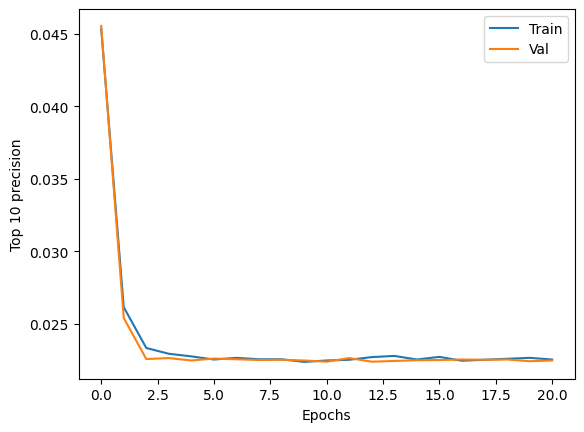

In [ ]:
plt.plot(epochs_tracked, [precision for precision, _ in train_topks],
         label="Train")
plt.plot(epochs_tracked, [precision for precision, _ in val_topks],
         label="Val")
plt.ylabel(f"Top {K} precision")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Plot top K recall over epochs


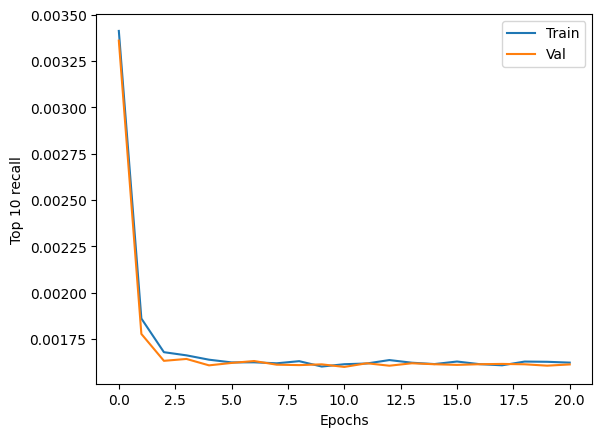

In [ ]:
plt.plot(epochs_tracked, [recall for _, recall in train_topks],
         label="Train")
plt.plot(epochs_tracked, [recall for _, recall in val_topks],
         label="Val")
plt.ylabel(f"Top {K} recall")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Test

Test model on the test set.

In [ ]:
# predict on the test set
lightGCN.eval()
print("Training completed after {} epochs".format(epochs))

users_test = samples_test[:, 0:1]
pos_test = samples_test[:, 1:2]
neg_test = samples_test[:, 2:3]

loss_test, reg_loss_test = bpr_loss(
    lightGCN, users_test, pos_test, neg_test, data, test_mask)
reg_loss_test = reg_loss_test * weight_decay

# predict on the test set
user_indices = samples_test[:, 0]
user_indices = user_indices.repeat(2).long()
item_indices = torch.cat((samples_test[:, 1], samples_test[:, 2])).long()
pred_test = getUsersRating(lightGCN, users_test[:,0], data)\
    [user_indices, item_indices]
truth_test = data["edge_index"][users_test.long()[:,0]]\
    [user_indices, item_indices]
test_topk_precision, test_topk_recall = personalized_topk(
    pred_test, K, user_indices, data["edge_index"])

print("Average bpr_loss on the test set is {}, and regularization loss is {}.\n".format(round(float((loss_test+reg_loss_test)/len(samples_test)), 6),
                                                                                                round(float(reg_loss_test/len(samples_test)), 6)),
      "Top K precision = {}, recall = {}.".format(test_topk_precision, test_topk_recall))

# Save model embeddings.
torch.save(lightGCN, config_dict["model_name"])

print(f"Model state dictionary saved to {config_dict['model_name']}")



Training completed after 21 epochs
Average bpr_loss on the test set is 2e-06, and regularization loss is 0.0.
 Top K precision = 0.022367549668873832, recall = 0.0016056076799480653.
Model state dictionary saved to model.pth


# Run matrix factorization as baseline performance

As a baseline, Run [PARAFAC matrix factorization](https://www.sciencedirect.com/science/article/abs/pii/S0169743997000324) on the dataset. Use the [TensorLy](http://tensorly.org/dev/modules/generated/tensorly.decomposition.parafac.html#tensorly.decomposition.parafac) library.

In [ ]:
def matrix_factorization(user_item, rank):
    """Runs matrix factorization on `user_item` and get user-item similarities.

    Args:
        user_item: User-item connectivity matrix.
        rank: Number of numbers to represent a user / item.

    Returns:
        User-item similarities.
    """
    weights, (user_factors, item_factors) = \
        decomposition.parafac(user_item, rank)
    similarities = user_factors @ item_factors.T
    return 1 / (1 + np.exp(- similarities))

Observe that LightGCN model delivers betters performance than matrix factorization.

In [ ]:
# Compute baseline metrics using matrix factorization.
baseline_pred = matrix_factorization(
        data["edge_index"].detach().cpu().numpy(),
        config_dict["mf_rank"])[user_indices.cpu(), item_indices.cpu()]
baseline_topk_precision, baseline_topk_recall = \
        personalized_topk(baseline_pred, K, user_indices, data["edge_index"])
print("Baseline (PARAFAC matrix factorization) produces ",
      "Top K precision = {}, recall = {}.".format(baseline_topk_precision,
                                                  baseline_topk_recall))

Baseline (PARAFAC matrix factorization) produces  Top K precision = 0.06466887417218621, recall = 0.004758460762752693.


# Demo

In [ ]:
root = os.getcwd()
movielens = MovieLens(root=root, transform=trans_ml)
data = movielens.get()

def get_top_movie_recommendations(user_id, num_recommendations=10):
    """
    Generate movie recommendations for a specific user

    Args:
        user_id: ID of the user to generate recommendations for (1-indexed)
        num_recommendations: Number of recommendations to return

    Returns:
        List of dictionaries containing recommended movie information
    """
    # Load the trained model
    model = torch.load(config_dict["model_name"], weights_only=False)
    model.eval()

    # Adjust user_id to 0-indexed
    user_index = user_id - 1

    # Load movie data
    with zipfile.ZipFile(os.path.join(root, "raw/ml-1m.zip"), 'r') as zip_ref:
        if not os.path.exists(os.path.join(root, "raw/ml-1m/movies.dat")):
            zip_ref.extract("ml-1m/movies.dat", os.path.join(root, "raw"))

    # Load movie information
    mnames = ['movie_id', 'title', 'genres']
    movies_df = pd.read_table(os.path.join(root, "raw/ml-1m/movies.dat"),
                          sep='::', header=None, names=mnames,
                          engine='python', encoding='latin-1')

    # Get user-item ratings
    all_ratings = getUsersRating(model, torch.tensor([user_index]), data)
    user_ratings = all_ratings[0]  # Ratings for this specific user

    # Find movies the user has already watched (from raw ratings matrix)
    watched_movies = set(torch.nonzero(data["raw_edge_index"][user_index] > 0).squeeze().cpu().tolist())
    if not isinstance(watched_movies, set):
        watched_movies = {watched_movies}

    # Create a mask to filter out already watched movies
    mask = torch.ones_like(user_ratings, dtype=torch.bool)
    for idx in watched_movies:
        mask[idx] = False

    # Get top K recommendations (excluding watched movies)
    filtered_ratings = user_ratings * mask
    _, top_indices = torch.topk(filtered_ratings, min(num_recommendations, int(mask.sum())))
    top_indices = top_indices.cpu().tolist()

    # Format recommendations
    recommendations = []
    for idx in top_indices:
        movie_id = idx + 1  # Convert 0-based index to 1-based movie_id
        movie_info = movies_df[movies_df['movie_id'] == movie_id]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title']
            genres = movie_info.iloc[0]['genres']
            score = user_ratings[idx].item()
            recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'score': score
            })

    return recommendations

def display_recommendations(user_id, num_recommendations=10):
    """Display formatted movie recommendations for a user"""
    recommendations = get_top_movie_recommendations(user_id, num_recommendations)

    print(f"\nTop {num_recommendations} Movie Recommendations for User {user_id}:")
    print("="*80)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} ({rec['genres']})")

    return recommendations

# Example
if __name__ == "__main__":
    display_recommendations(user_id=22, num_recommendations=10)
    display_recommendations(user_id=105, num_recommendations=10)
    display_recommendations(user_id=3054, num_recommendations=10)
    display_recommendations(user_id=4760, num_recommendations=10)
    display_recommendations(user_id=5433, num_recommendations=10)
    display_recommendations(user_id=6030, num_recommendations=10)


Top 10 Movie Recommendations for User 22:
1. Licence to Kill (1989) (Action)
2. King of Masks, The (Bian Lian) (1996) (Drama)
3. Toy Story (1995) (Animation|Children's|Comedy)
4. Jumanji (1995) (Adventure|Children's|Fantasy)
5. Sabrina (1995) (Comedy|Romance)
6. Tom and Huck (1995) (Adventure|Children's)
7. Heat (1995) (Action|Crime|Thriller)
8. Father of the Bride Part II (1995) (Comedy)
9. Grumpier Old Men (1995) (Comedy|Romance)
10. Waiting to Exhale (1995) (Comedy|Drama)

Top 10 Movie Recommendations for User 105:
1. Careful (1992) (Comedy)
2. Jumanji (1995) (Adventure|Children's|Fantasy)
3. Waiting to Exhale (1995) (Comedy|Drama)
4. Tom and Huck (1995) (Adventure|Children's)
5. Sudden Death (1995) (Action)
6. Toy Story (1995) (Animation|Children's|Comedy)
7. Grumpier Old Men (1995) (Comedy|Romance)
8. Sabrina (1995) (Comedy|Romance)
9. GoldenEye (1995) (Action|Adventure|Thriller)
10. Father of the Bride Part II (1995) (Comedy)

Top 10 Movie Recommendations for User 3054:
1. Sudde